In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.0.0'

In [3]:
import tensorflow_datasets as tfds

### Importing Malaria dataset

In [4]:
# This was required because tfds.load('malaria') was giving a InsecureRequestWarning
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

In [5]:
mal_data = tfds.load('malaria')

##### Converting to numpy for data exploration

In [6]:
mal_data = tfds.as_numpy(mal_data)

In [7]:
len(mal_data)

1

In [8]:
type(mal_data)

dict

In [9]:
mal_data.keys()

dict_keys(['train'])

In [10]:
mal_data.values()

dict_values([<generator object _eager_dataset_iterator at 0x7f7d46933990>])

In [11]:
mal_data_npy = mal_data['train']

In [12]:
type(mal_data_npy)

generator

In [13]:
for i in mal_data_npy:
  temp = i
  print(i)
  break

{'image': array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 'label': 1}


In [14]:
feature_list = []
label_list = []
for i in mal_data_npy:
  feature_list.append(i['image'])
  label_list.append(i['label'])

In [15]:
len(feature_list)

27557

In [16]:
feature_list.append(temp['image'])
label_list.append(temp['label'])

In [17]:
len(label_list)

27558

#### Plotting

In [18]:
import matplotlib.pyplot as plt

%matplotlib inline

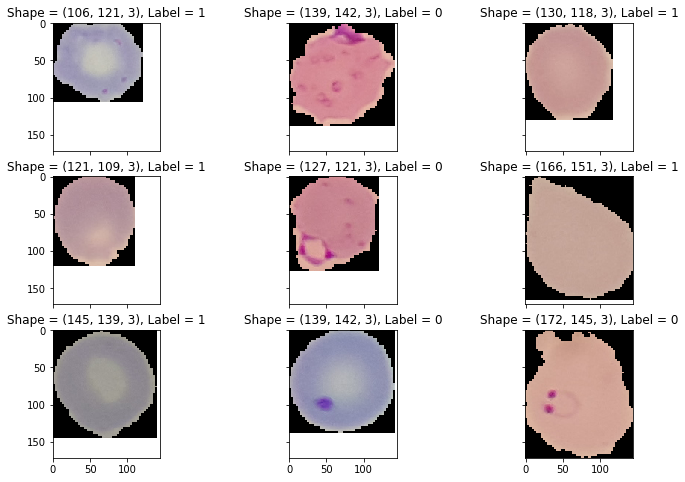

In [19]:
fig1, ax1 = plt.subplots(3,3, sharex=True, sharey=True, figsize = (12,8))
ax1 = ax1.flatten()
for i,j,k in zip(range(len(ax1)), feature_list, label_list):
  ax1[i].imshow(j)
  ax1[i].set_title('Shape = ' + str(j.shape) + ', Label = ' + str(k))
plt.show()

  * Different input sizes but all with 3 channels

### Data Preprocessing

In [20]:
import numpy as np

In [21]:
feature_list = np.array(feature_list)

In [22]:
feature_list[0].shape

(106, 121, 3)

In [23]:
label_list = np.array(label_list)

In [24]:
label_list = label_list.astype('uint8')

#### <br /> Checking the image size (height, width) distribution <br />


In [25]:
shape_list = []
for i in feature_list:
  shape = i.shape
  shape_list.append([shape[0], shape[1]])

shape_list = np.array(shape_list)

In [26]:
shape_list.shape

(27558, 2)

In [27]:
# Minimum dimension size (height, width)
min_shape_val = np.min(shape_list, axis=0)
min_shape_val

array([40, 46])

In [28]:
# Maximum dimension size (height, width)
max_shape_val = np.max(shape_list, axis=0)
max_shape_val

array([385, 394])

In [29]:
# Mean dimension size (height, width)
mean_shape_val = np.mean(shape_list, axis=0)
mean_shape_val

array([132.98345308, 132.48715437])

In [30]:
# standard deviation of the dimension size (height, width)
std_shape_val = np.std(shape_list, axis=0)
std_shape_val

array([20.61927562, 20.01558555])

In [31]:
# median of the dimension size (height, width)
median_shape_val = np.median(shape_list, axis=0)
median_shape_val

array([130., 130.])

### Resizing value

Warning if image shape is not of the right dimensions

datascience/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, 

In [32]:
# resize = np.round(mean_shape_val).astype('uint8')
# Majority of the Transfer learning models require square input, i.e. width = height.
resize = 128
resize

128

##### memory consumption till here is 1.6 GB <br />

        * All images need to be resized to the same dimension (height, width) for creating a tf.data.Dataset object
       
        
        

##### using tf.image module, with the option of various resizes methods, to resize the images

In [33]:
# timeit module to time the whole script
import time

def resizing_fn(feature_list):
    
    start_time = time.time()

    resized_feature_list = []
    for i,j in enumerate(feature_list):
        img_resize = tf.image.resize_with_pad(j, resize[0], resize[1], method = 'lanczos3', antialias=True)
        resized_feature_list.append(img_resize.numpy())

    end_time = time.time()
    time_for_resizing = end_time - start_time

    print('Time taken for resizing: %0.1f seconds' %(end_time - start_time))
    
    return np.array(resized_feature_list)

In [34]:
# Garbage collection
import gc

start_time = time.time()

resized_feature_list = []
for i in feature_list:
    img_resize = tf.image.resize_with_pad(i, resize[0], resize[1], method = 'lanczos3', antialias=True)
    resized_feature_list.append(img_resize)

end_time = time.time()
time_for_resizing = end_time - start_time

print(time_for_resizing) # time the resizing operation in seconds


In [35]:
from joblib import Parallel, delayed
def resizing_tf(i):
    
    return tf.image.resize_with_pad(image = i, target_height = resize, 
                                    target_width=resize, method = 'lanczos3', antialias=True).numpy()
def resizing_fn(feature_list):
    
    start_time = time.time()
    
    resized_feature_list = Parallel(n_jobs=3)(delayed(resizing_tf)(i) for i in feature_list)
    
    end_time = time.time()
    
    print('Time taken for resizing: %0.1f seconds' %(end_time - start_time))
    
    return np.array(resized_feature_list)

    
Using joblib to parallelize reduces the processing time for sure but results in increased RAM consumption.

Also, unable to clear memory using

    del resized_feature_list
    gc.collect()

tested by defining within the function itself <br />

Time taken for resizing: 2.0 seconds


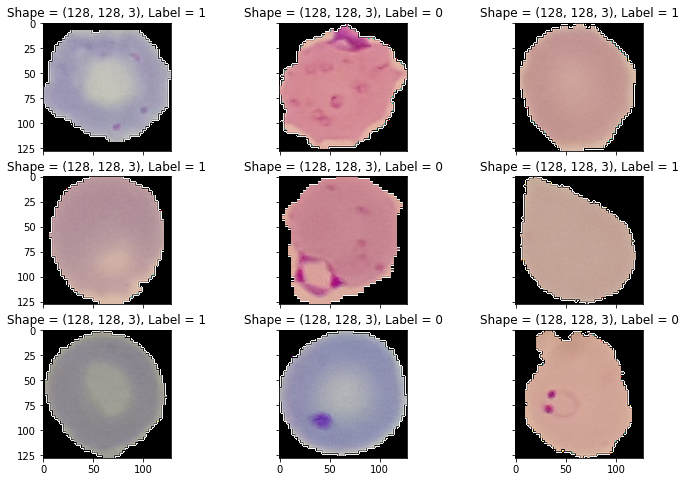

In [36]:
# Plotting the resized images
fig2, ax2 = plt.subplots(3,3, sharex=True, sharey=True, figsize = (12,8))
ax2 = ax2.flatten()

for i,j,k in zip(range(len(ax2)), resizing_fn(feature_list[:9]), label_list[:9]):
    ax2[i].imshow(tf.cast(j, 'uint8')) # plt.imshow clips input data to range [0,255] for integers
    ax2[i].set_title('Shape = ' + str(j.shape) + ', Label = ' + str(k))

plt.show()

#### Converting y labels to categorical

In [37]:
type(label_list)

numpy.ndarray

In [38]:
np.unique(label_list)

array([0, 1], dtype=uint8)

In [39]:
np.bincount(label_list)

array([13779, 13779])

In [40]:
from sklearn.preprocessing import OneHotEncoder

In [41]:
onehotencoder = OneHotEncoder(sparse = False)

In [42]:
categorical_labels = onehotencoder.fit_transform(label_list.reshape(-1,1))

/home/sameer/datascience/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [43]:
onehotencoder.categories_

[array([0., 1.])]

In [44]:
onehotencoder.get_feature_names()

array(['x0_0.0', 'x0_1.0'], dtype=object)

In [45]:
type(label_list)

numpy.ndarray

In [46]:
categorical_labels[1]

array([1., 0.])

### Creating TF dataset for training

##### Shuffling the data before splitting into training, validation and test in the ratio 0.8,0.1,0.1

In [47]:
# concat_data = np.concatenate((feature_list.reshape(-1,1), label_list.reshape(-1,1)), axis=1)
# concat_data.shape

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
random_seed = 100

In [50]:
x_train, x_test, y_train, y_test = train_test_split(resizing_fn(feature_list), categorical_labels, test_size=0.1, shuffle = True, 
                                                    random_state=random_seed, stratify = label_list)

Time taken for resizing: 47.5 seconds


In [51]:
len(x_train)

24802

In [52]:
type(x_train)

numpy.ndarray

In [53]:
x_train.shape

(24802, 128, 128, 3)

In [54]:
len(x_test)

2756

In [55]:
x_train_shape = x_train[:].shape
x_train_shape

(24802, 128, 128, 3)

In [56]:
x_test_shape = x_test.shape
x_test_shape

(2756, 128, 128, 3)

#### Scaling the data

In [57]:
from sklearn.preprocessing import StandardScaler

In [58]:
np.min(x_train)

-66.77345

In [59]:
np.max(x_train)

317.9566

In [60]:
std_scaler = StandardScaler()

In [61]:
scaler_fit = std_scaler.fit(x_train[:].reshape(x_train_shape[0]*x_train_shape[1]*x_train_shape[2], x_train_shape[3]))

In [62]:
x_train_scaled = scaler_fit.transform(x_train.reshape(x_train_shape[0]*x_train_shape[1]*x_train_shape[2], x_train_shape[3]))

In [63]:
x_train_scaled = x_train_scaled.reshape(x_train_shape[0], x_train_shape[1], x_train_shape[2], x_train_shape[3])

In [64]:
x_train_scaled.shape

(24802, 128, 128, 3)

In [65]:
np.min(x_train_scaled)

-2.082073

In [66]:
np.max(x_train_scaled)

2.5491774

In [67]:
x_test_scaled = scaler_fit.transform(x_test.reshape(x_test_shape[0]*x_test_shape[1]*x_test_shape[2], x_test_shape[3]))

In [68]:
x_test_scaled = x_test_scaled.reshape(x_test_shape[0],x_test_shape[1],x_test_shape[2], x_test_shape[3])
x_test_scaled.shape

(2756, 128, 128, 3)

In [69]:
np.min(x_test_scaled)

-2.0594797

In [70]:
np.max(x_test_scaled)

2.28391

In [71]:
# validation size will be
1/9

0.1111111111111111

In [72]:
x_train_scaled, x_valid_scaled, y_train, y_valid = train_test_split(x_train_scaled, y_train, test_size=0.11, shuffle = True, 
                                                    random_state=random_seed, stratify = y_train)

In [73]:
len(x_train_scaled)

22073

In [74]:
len(x_valid_scaled)

2729

In [75]:
del x_train, x_test
gc.collect()

262

#### Creating a tf.data dataset

In [82]:
# need to have the right label names
input_label = 'image' 
output_label = 'disease_label'

In [83]:
starttime =time.time()
train_dataset = tf.data.Dataset.from_tensor_slices(({input_label:x_train_scaled}, {output_label:y_train}))
endtime = time.time()

In [84]:
endtime-starttime

2.383526086807251

In [86]:
for test_image in train_dataset.take(1):
    print(test_image)

({'image': <tf.Tensor: id=71288, shape=(128, 128, 3), dtype=float32, numpy=
array([[[-1.3269409, -1.3147606, -1.3284621],
        [-1.3269409, -1.3147606, -1.3284621],
        [-1.3269409, -1.3147606, -1.3284621],
        ...,
        [-1.3269409, -1.3147606, -1.3284621],
        [-1.3269409, -1.3147606, -1.3284621],
        [-1.3269409, -1.3147606, -1.3284621]],

       [[-1.3269409, -1.3147606, -1.3284621],
        [-1.3269409, -1.3147606, -1.3284621],
        [-1.3269409, -1.3147606, -1.3284621],
        ...,
        [-1.3269409, -1.3147606, -1.3284621],
        [-1.3269409, -1.3147606, -1.3284621],
        [-1.3269409, -1.3147606, -1.3284621]],

       [[-1.3269409, -1.3147606, -1.3284621],
        [-1.3269409, -1.3147606, -1.3284621],
        [-1.3269409, -1.3147606, -1.3284621],
        ...,
        [-1.3269409, -1.3147606, -1.3284621],
        [-1.3269409, -1.3147606, -1.3284621],
        [-1.3269409, -1.3147606, -1.3284621]],

       ...,

       [[-1.3269409, -1.3147606, -1.32

In [87]:
validation_dataset = tf.data.Dataset.from_tensor_slices(({input_label:x_valid_scaled}, {output_label:y_valid}))
test_dataset = tf.data.Dataset.from_tensor_slices(({input_label:x_test_scaled}, {output_label:y_test}))

        * Huge increase in memory consumption. Total is 1.6 GB + 5.4 GB + 6.0 GB

In [88]:
del x_train_scaled, x_test_scaled, x_valid_scaled
gc.collect()

3909

In [89]:
batch_size = 16
# shuffle_buffer_size = 1000, no need to shuffle as already shuffled by train_test_split function of sklearn

In [90]:
train_dataset = train_dataset.batch(batch_size=batch_size, drop_remainder=True)
validation_dataset = validation_dataset.batch(batch_size=batch_size)
test_dataset = test_dataset.batch(batch_size=batch_size)

In [91]:
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [92]:
gc.collect()

0

### Base Model for Transfer Learning

In [76]:
image_shape = (resize, resize, 3)
image_shape

(128, 128, 3)

In [79]:
input_layer =  tf.keras.layers.Input(shape=image_shape, batch_size=None, name = 'image')

In [100]:
tf.keras.backend.clear_session()

In [98]:
# Not including the input_shape here as the input_layer cannot be renamed
base_model = tf.keras.applications.MobileNetV2(include_top = False, weights = 'imagenet')

/home/sameer/datascience/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [101]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
_______________________________________________________________________________

In [120]:
base_model.trainable = False

In [121]:
output_from_basemodel = base_model(input_layer)

In [122]:
output_from_basemodel.shape

TensorShape([None, 4, 4, 1280])

* Testing

In [95]:
for test_image, test_label in train_dataset.take(1):
    break

In [104]:
print(base_model(test_image).shape)

(16, 4, 4, 1280)


In [105]:
global_pooling_layer = tf.keras.layers.GlobalAveragePooling2D(data_format='channels_last')

In [106]:
global_pooling_layer(base_model(test_image)).shape

TensorShape([16, 1280])

In [109]:
fc_layer = tf.keras.layers.Dense(units = 2)

In [110]:
fc_layer(global_pooling_layer(base_model(test_image)))

<tf.Tensor: id=84325, shape=(16, 2), dtype=float32, numpy=
array([[-0.987419  ,  0.60740113],
       [-1.8784158 ,  1.8470082 ],
       [ 0.24190575,  1.9121573 ],
       [ 1.6518005 , -0.815214  ],
       [-1.1117821 , -0.16209775],
       [-0.9336454 ,  1.8879719 ],
       [ 0.47589225,  0.9061211 ],
       [-2.2027354 ,  2.7864668 ],
       [-0.943815  ,  2.3355737 ],
       [-0.83518505,  0.7561829 ],
       [-1.0957983 ,  1.0097857 ],
       [ 0.23993677,  1.2341114 ],
       [ 0.1692347 ,  1.6386415 ],
       [ 0.7961185 ,  0.18704188],
       [-0.12592602, -0.5513597 ],
       [ 0.12187767,  1.1129222 ]], dtype=float32)>

In [111]:
fc_layer = tf.keras.layers.Dense(units = 2, activation='softmax', name = output_label)
fc_layer(global_pooling_layer(base_model(test_image)))

<tf.Tensor: id=85119, shape=(16, 2), dtype=float32, numpy=
array([[0.72997636, 0.27002367],
       [0.99806434, 0.00193562],
       [0.99510217, 0.0048978 ],
       [0.8966703 , 0.10332969],
       [0.9761313 , 0.02386874],
       [0.99067116, 0.00932882],
       [0.9679957 , 0.03200432],
       [0.98869085, 0.0113091 ],
       [0.9941088 , 0.00589121],
       [0.9925237 , 0.00747633],
       [0.98467076, 0.01532929],
       [0.5926814 , 0.40731862],
       [0.8020957 , 0.19790427],
       [0.96975255, 0.03024742],
       [0.9483275 , 0.05167253],
       [0.9771713 , 0.02282868]], dtype=float32)>

* End Testing

In [112]:
dropout_rate = 0.3
dropout_layer = tf.keras.layers.GaussianDropout(rate = dropout_rate)

In [123]:
dense_layer = dropout_layer(global_pooling_layer(output_from_basemodel), training =True)
# dense_layer = global_pooling_layer(base_model.output)
output_layer = tf.keras.layers.Dense(units=2, activation = 'softmax', name = output_label)(dense_layer)

In [124]:
tf.keras.backend.clear_session()

In [125]:
model = tf.keras.Model(inputs=input_layer, outputs = output_layer)

In [126]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) multiple                  2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
gaussian_dropout (GaussianDr (None, 1280)              0         
_________________________________________________________________
disease_label (Dense)        (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


* Testing

In [127]:
# The values are not constant when there is a dropout layer in between, change with each execution
model(test_image)

<tf.Tensor: id=89556, shape=(16, 2), dtype=float32, numpy=
array([[8.7247318e-01, 1.2752683e-01],
       [8.6008338e-03, 9.9139917e-01],
       [7.0958734e-01, 2.9041266e-01],
       [3.7918788e-01, 6.2081212e-01],
       [2.6079640e-02, 9.7392040e-01],
       [1.3799927e-01, 8.6200070e-01],
       [2.0044851e-03, 9.9799550e-01],
       [5.5256317e-04, 9.9944741e-01],
       [2.0589277e-03, 9.9794108e-01],
       [6.2755954e-01, 3.7244043e-01],
       [9.4147718e-01, 5.8522824e-02],
       [3.0084401e-01, 6.9915599e-01],
       [2.2783561e-02, 9.7721648e-01],
       [2.3307005e-01, 7.6692998e-01],
       [2.6534057e-01, 7.3465949e-01],
       [5.1143926e-01, 4.8856080e-01]], dtype=float32)>

In [128]:
tf.argmax(model(test_image), axis = 1)

<tf.Tensor: id=90337, shape=(16,), dtype=int64, numpy=array([0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0])>

In [129]:
test_label.keys()

dict_keys(['disease_label'])

In [130]:
list(test_label.values())[0].numpy()

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [131]:
tf.argmax(list(test_label.values())[0], axis=1)

<tf.Tensor: id=90339, shape=(16,), dtype=int64, numpy=array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1])>

* End Testing

### Callbacks

In [132]:
cb_list = []

#### <i> Early Stopping CallBack <i/>

In [133]:
cb_early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta=1e-3, 
                                                    patience = 2)
cb_list.append(cb_early_stopping)

#### <i> Saving Model CallBack <i/>

In [134]:
import os

In [135]:
savedmodel_pathname = 'saved_models'
if os.path.exists(savedmodel_pathname):
    pass
else:
    os.mkdir(savedmodel_pathname)

cb_model_chkpt = tf.keras.callbacks.ModelCheckpoint(filepath=savedmodel_pathname + '/' + 
                                                   'model_{epoch}-{val_loss:.3f}.h5', monitor = 'val_loss', 
                                                   verbose=1, save_best_only =True)
cb_list.append(cb_model_chkpt)

#### <i> Dynamic Learning Rate CallBack <i/>

In [136]:
cb_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, verbose=1, patience = 1)
cb_list.append(cb_lr)

#### <i> TensorBoard <i/>

In [137]:
tensorboard_pathname = 'logs'
if os.path.exists(tensorboard_pathname):
    pass
else:
    os.mkdir(tensorboard_pathname)

cb_tensorboard = tf.keras.callbacks.TensorBoard(log_dir = tensorboard_pathname, histogram_freq=1)
cb_list.append(cb_tensorboard)

### Compiling

In [138]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = .01), 
             loss = tf.keras.losses.categorical_crossentropy, metrics = ['accuracy'])

In [139]:
len(model.trainable_variables)

2

In [140]:
# Evaluating the model metrics before fitting
initial_val_loss, initial_val_accuracy =  model.evaluate(validation_dataset)

171/171 [==============================] - 21s 121ms/step - loss: 1.8738 - accuracy: 0.4357


### Model Fitting

In [142]:
initial_epochs = 10
history = model.fit(train_dataset, epochs=initial_epochs, 
                    verbose = 1, callbacks=cb_list, validation_data=validation_dataset)

Epoch 1/10
   1379/Unknown - 263s 191ms/step - loss: 0.9030 - accuracy: 0.8388
Epoch 00001: val_loss improved from inf to 3.56914, saving model to saved_models/model_1-3.569.h5
1379/1379 [==============================] - 282s 205ms/step - loss: 0.9030 - accuracy: 0.8388 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
1378/1379 [============================>.] - ETA: 0s - loss: 1.0385 - accuracy: 0.8461
Epoch 00002: val_loss improved from 3.56914 to 3.24088, saving model to saved_models/model_2-3.241.h5
1379/1379 [==============================] - 282s 205ms/step - loss: 1.0385 - accuracy: 0.8461 - val_loss: 3.2409 - val_accuracy: 0.7468
Epoch 3/10
1378/1379 [============================>.] - ETA: 0s - loss: 1.0936 - accuracy: 0.8466
Epoch 00003: val_loss did not improve from 3.24088
1379/1379 [==============================] - 288s 209ms/step - loss: 1.0936 - accuracy: 0.8464 - val_loss: 7.2005 - val_accuracy: 0.6043
Epoch 4/10
1378/1379 [============================>.] -

#### Test Accuracy

In [150]:
model.evaluate(test_dataset)

173/173 [==============================] - 19s 111ms/step - loss: 3.3194 - accuracy: 0.7329


[3.3193562691546763, 0.7329463]

     * Overfitting

#### Changing hyperparameters

In [153]:
cb_lr.params

{'batch_size': None,
 'epochs': 10,
 'steps': 1379,
 'samples': None,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [154]:
cb_lr.patience

2

In [155]:
cb_lr.patience = 1

In [156]:
cb_lr.patience

1

In [157]:
# rebatching
batch_size = 32
train_dataset = train_dataset.unbatch().batch(batch_size=batch_size).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.unbatch().batch(batch_size=batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.unbatch().batch(batch_size=batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [163]:
for i in train_dataset.take(1):
    print(i[0]['image'].shape)
    break

(32, 128, 128, 3)


#### Loading saved best model

In [198]:
del model

In [199]:
tf.keras.backend.clear_session()

In [200]:
model = tf.keras.models.load_model(os.path.join(savedmodel_pathname, 'model_5-3.148.h5'),compile=False)

In [201]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) multiple                  2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
gaussian_dropout (GaussianDr (None, 1280)              0         
_________________________________________________________________
disease_label (Dense)        (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


#### Compiling

In [202]:
model.compile(optimizer =  tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = tf.keras.losses.categorical_crossentropy, metrics = ['accuracy'])

In [203]:
history.epoch

[0, 1, 2, 3, 4, 5, 6]

In [204]:
epochs_2 = 15
history_2 = model.fit(train_dataset, epochs=epochs_2, verbose = 1, callbacks=cb_list, 
                      validation_data=validation_dataset, initial_epoch=history.epoch[-1])

Epoch 7/15
    690/Unknown - 267s 387ms/step - loss: 0.6798 - accuracy: 0.8782
Epoch 00007: val_loss improved from 3.14769 to 1.46825, saving model to saved_models/model_7-1.468.h5
690/690 [==============================] - 287s 416ms/step - loss: 0.6798 - accuracy: 0.8782 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 8/15
85/86 [============================>.] - ETA: 0s - loss: 0.6330 - accuracy: 0.8776
Epoch 00008: val_loss improved from 1.46825 to 1.08592, saving model to saved_models/model_8-1.086.h5
690/690 [==============================] - 279s 404ms/step - loss: 0.5582 - accuracy: 0.8859 - val_loss: 1.0859 - val_accuracy: 0.8435
Epoch 9/15
85/86 [============================>.] - ETA: 0s - loss: 0.5518 - accuracy: 0.8790
Epoch 00009: val_loss improved from 1.08592 to 0.97383, saving model to saved_models/model_9-0.974.h5
690/690 [==============================] - 277s 401ms/step - loss: 0.4698 - accuracy: 0.8850 - val_loss: 0.9738 - val_accuracy: 0.8417
Epoch 10/15
85

#### Test Accuracy

In [207]:
model.evaluate(test_dataset)

87/87 [==============================] - 19s 219ms/step - loss: 0.4268 - accuracy: 0.8596


[0.42683802879062194, 0.8595791]

#### Plotting

In [209]:
history.epoch

[0, 1, 2, 3, 4, 5, 6]

In [210]:
history.history

{'loss': [0.9029751952446379,
  1.0388308463997293,
  1.0948972908119308,
  1.100454830629913,
  1.0833327521883853,
  1.0763498083684229,
  1.1557441983024936],
 'accuracy': [0.8388325,
  0.8460841,
  0.8464467,
  0.84712654,
  0.8472625,
  0.84735316,
  0.84812367],
 'val_loss': [3.5691353263420793,
  3.2408808086091945,
  7.200453162193298,
  3.2223285684179603,
  3.147685241090906,
  5.438651796299637,
  3.418948390025493],
 'val_accuracy': [0.7233419,
  0.7467937,
  0.60425067,
  0.73176986,
  0.7742763,
  0.67130816,
  0.72810555],
 'lr': [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]}

In [211]:
history.history['val_accuracy']

[0.7233419,
 0.7467937,
 0.60425067,
 0.73176986,
 0.7742763,
 0.67130816,
 0.72810555]

history_2 commenced from model-5 of history

In [205]:
history_2.epoch

[6, 7, 8, 9, 10, 11, 12, 13, 14]

In [212]:
history_2.history['val_accuracy']

[0.8438989,
 0.84353244,
 0.84170026,
 0.82924145,
 0.8420667,
 0.83730304,
 0.84902894,
 0.8556248,
 0.8578234]

In [214]:
import matplotlib.pyplot as plt
%matplotlib inline

In [228]:
epoch_list = history.epoch[:-2] + history_2.epoch
epoch_list

[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [231]:
val_acc_list =  history.history['val_accuracy'][:-2] + history_2.history['val_accuracy']

In [230]:
train_acc_list =  history.history['accuracy'][:-2] + history_2.history['accuracy']

In [232]:
val_loss_list =  history.history['val_loss'][:-2] + history_2.history['val_loss']

In [235]:
train_loss_list =  history.history['loss'][:-2] + history_2.history['loss']

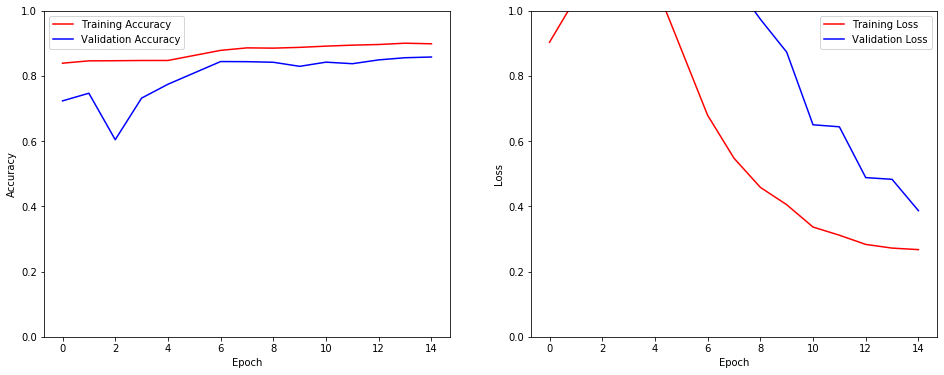

In [239]:
fig1, ax1 =  plt.subplots(nrows = 1, ncols =2, figsize=(16,6))

# plotting accuracies
ax1[0].plot(epoch_list, train_acc_list, 'r-', label = 'Training Accuracy')
ax1[0].plot(epoch_list, val_acc_list, 'b-', label = 'Validation Accuracy')

# plotting losses
ax1[1].plot(epoch_list, train_loss_list, 'r-', label = 'Training Loss')
ax1[1].plot(epoch_list, val_loss_list, 'b-', label = 'Validation Loss')

[i.set_xlabel('Epoch') for i in ax1]

ax1[0].set_ylabel('Accuracy')
ax1[1].set_ylabel('Loss')

[i.set_ylim([0,1]) for i in ax1]

[i.legend(loc = 'best') for i in ax1]

plt.show()

### Fine Tuning

In [ ]:
base_model.trainable = True

In [ ]:
tf.keras